# Mock Observations with MUSTANG-2

We use Maria to generate synthetic mock observations for bolometric arrays installed on single-dish telescopes. The tool consists of four parts: An input map, an observing plan, an instrument, and a site. All are then combined in a wrapper named Simulation. As explained in the section "Usage", we can emulate all kinds of telescopes, like ACT, Toltec, GBT, and AtLAST. 

The simulation tool generates time-ordered domain (TOD) data. By simulating distinct atmospheric layers corresponding to the designated site within the simulation, we allow the mock array to sweep across the input celestial sky while scanning through the evolving atmosphere. As a result, the TODs produced combine elements of the real sky and atmospheric and detector noise.

This tutorial will guide you through the process of setting up the simulation tool and creating your own mock observations -- In particular for GBT/MUSTANG-2 like observations of a galaxy cluster. 

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import maria

## Setting up a MUSTANG-2 Simulation
`maria` offers flexibility for customizing atmospheric simulations. You can configure it to replicate observatories like 'AtLAST' at the APEX site or simulate specific observations, such as MUSTANG-2, under different weather conditions by adjusting the observing time.

### Input map

First we specify the input map, our astronomical signal from which we want to make a mock observation. You can give it a fits file and load the map as outlined below. Don't forgot to put the map at an RA and Dec (in degrees) in the sky. Also, the width or the pixel size (resolution) needs to be specified. 

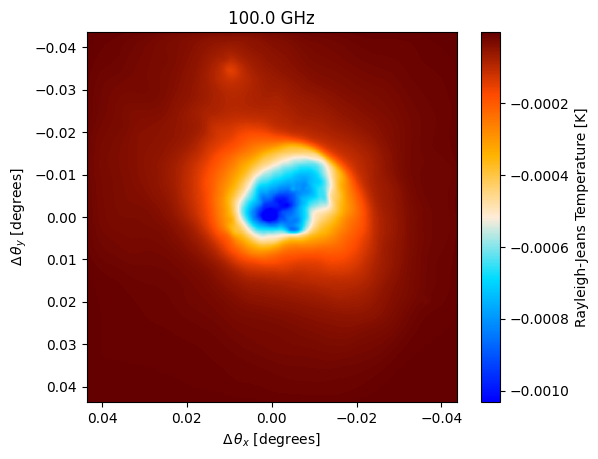

In [3]:
map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

### Observing strategy
Below we define the observing strategy containing the duration, integration time, read out rate, and pointing center

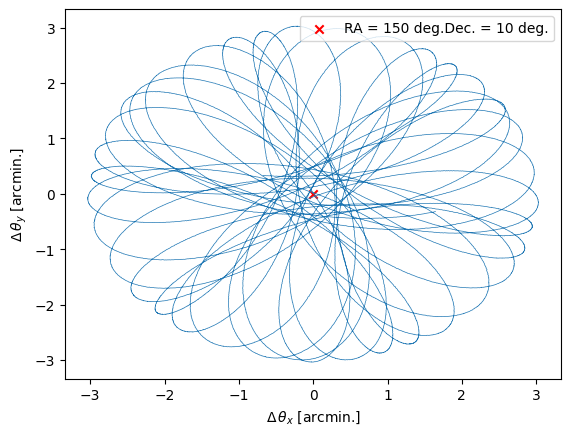

In [5]:

#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

### Define instrument
We have configuration files in place to mimic typical telescopes and instruments. To run a MUSTANG-2 like observations, simply initialize the instrument as follows. Other tutorials will go into more detail on how to adjust it to test out how telescope designs affect the recovered signal. 

In [6]:
instrument = maria.get_instrument('MUSTANG-2')

We can plot the instruments which will show the location of the detectors in the FoV with their diffrection limited beam size. The detectors for MUSTANG-2 are spaced at 2 f-lambda.

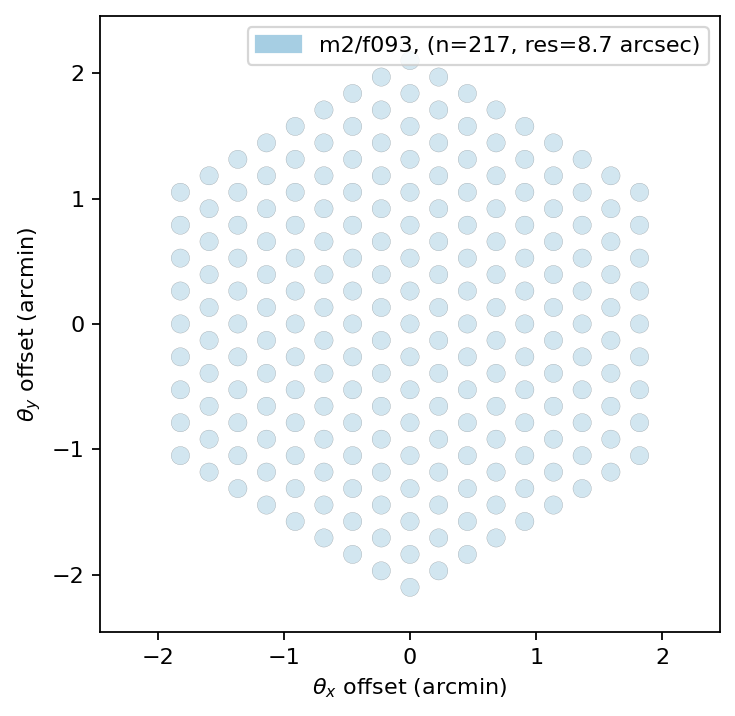

In [7]:
instrument.plot()

### Initialize the simulation
The simulation class combines all the components into one.

In [8]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                       cmb="generate",
                      )

2024-09-28 14:27:18.593 INFO: Initialized base in 833 ms.
Building atmosphere: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.31it/s]
2024-09-28 14:27:21.933 INFO: Initialized atmosphere in 3333 ms.
Generating CMB: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


## Obtaining time-ordered data (TODs)
To acquire time-ordered data (TODs), you only need to run the script. The TOD object contains time stamps, coordinates (in RA and Dec), and the intensity of each scan for every detector. The intensity units are expressed in power can be converted to surface brightness temperature units: Kelvin Rayleigh-Jeans (Even if the input map is given in Jy/pixel. We convert the units under the hood).

In [9]:
tod = sim.run()

Generating noise: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


In [11]:
tod.fields

['atmosphere', 'cmb', 'map', 'noise']

### Useful visualizations:

Now, let's visualize the TODS. The figure shows the mean powerspectra and a time series of the observations.

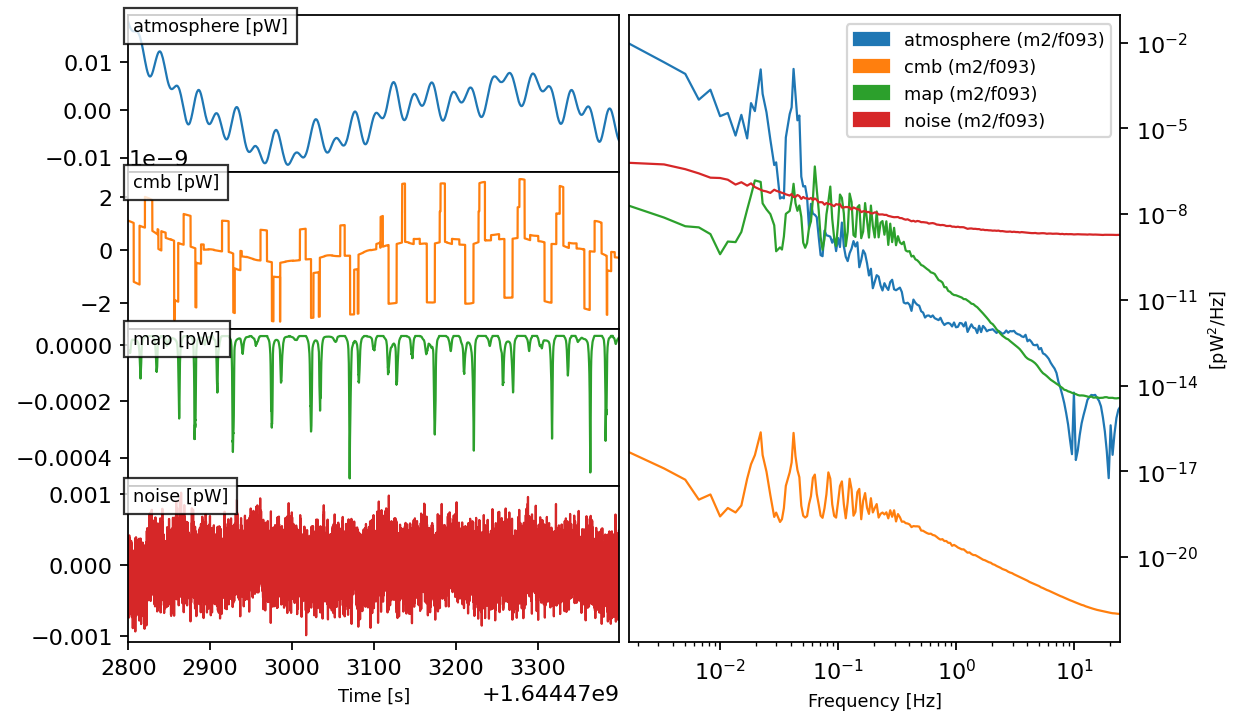

In [12]:
tod.plot()

## Mapping the TODs
To transform the TODs into images, you'll require a mapper. While there is an option to use your own mapper, we have also implemented one for your convenience. This built-in mapper follows a straightforward approach: it removes the common mode over all detectors (the atmosphere if you scan fast enough), then detrends and optionally Fourier filters the time-streams to remove any noise smaller than the resolution of the dish. Then, the mapper bins the TOD on the specified grid. Notably, the mapper is designed to effectively eliminate correlated atmospheric noise among different scans, thereby increasing SNR of the output map.

An example of how to run the mapper on the TOD is as follows:

In [14]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=0.1, 
                   height=0.1,
                   resolution=2e-4,
                   tod_preprocessing={
                        "remove_modes": {"n": 1},
                        # "highpass": {"f": 0.01},
                        "despline": {"knot_spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)
output_map = mapper.run()

Running mapper (m2/f093): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


## Visualizing the maps
As interesting as the detector setup, power spectra, and time series are, intuitively we think in the image plane. so let's visualize it! 

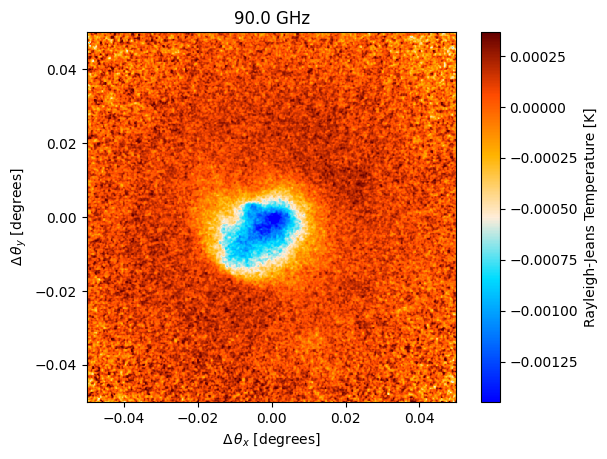

In [15]:
output_map.plot()

You can also save the map to a fits file. Here, we recover the units in which the map was initially specified in.

In [16]:
output_map.to_fits('/tmp/simulated_map.fits')